<a href="https://colab.research.google.com/github/kaicong12/CRNN-HandWriting-Recognition/blob/main/NewAuthorFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!mkdir -p words xml HTR_Using_CRNN/Model
!unzip -qq "/content/gdrive/MyDrive/Colab Notebooks/biased_ref.zip" -d "/content/biased_ref"

In [3]:
import numpy as np
import cv2
import os
import os.path as osp
import glob
import pandas as pd
import string
import matplotlib.pyplot as plt
from datetime import datetime
import xml.etree.cElementTree as et

from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Global Variables

In [22]:
# dataset related variables
MAX_LABEL_LEN = 0
CHAR_LIST = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []


# model related variables
BATCH_SIZE = 8
EPOCHS = 30
E = str(EPOCHS)
OPTIMIZER_NAME = 'sgd'

In [5]:
def extract_from_biased_ref(directory):
    words = []
    label_files = glob.glob(f"{directory}/*.png")

    for label_filepath in label_files:
        text = osp.splitext(label_filepath.split("_")[-1])[0]
        
        words.append({
            'image_filepath': label_filepath,
            'text': text
        })
    
    return words

In [6]:
data = extract_from_biased_ref("/content/biased_ref/biased_ref")

In [7]:
data[0]

{'image_filepath': '/content/biased_ref/biased_ref/synthetic_biased_ref(10423)_branniness.png',
 'text': 'branniness'}

In [8]:
# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(CHAR_LIST.index(chara))
        
    return dig_lst

In [9]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    cv2.normalize(img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return img

In [25]:
for index, word in enumerate(data):
    image_filepath = word['image_filepath']
    text = word['text']

    # processing on image
    img = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)

    try:
        img = process_image(img)
    except:
        raise Exception("Unable to process image")

    # processing on label
    try:
        label = encode_to_labels(text)
    except:
        raise Exception("Unable to process label")
    
    # added this line to prevent error from CTC computation
    if len(label) > 31:
      continue
    
    if index % 10 == 0:
        valid_images.append(img)
        valid_labels.append(label)
        valid_input_length.append(31)
        valid_label_length.append(len(text))
        valid_original_text.append(text)
    else:
        train_images.append(img)
        train_labels.append(label)
        train_input_length.append(31)
        train_label_length.append(len(text))
        train_original_text.append(text)
    
    if len(text) > MAX_LABEL_LEN:
        MAX_LABEL_LEN = len(text)

In [26]:
train_padded_labels = pad_sequences(train_labels, 
                      maxlen=MAX_LABEL_LEN, 
                      padding='post',
                      value=len(CHAR_LIST))

valid_padded_labels = pad_sequences(valid_labels, 
                      maxlen=MAX_LABEL_LEN, 
                      padding='post',
                      value=len(CHAR_LIST))

# Convert to numpy array.
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

# Model Building

In [12]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(CHAR_LIST)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

# Loss Function

In [13]:
the_labels = Input(name='the_labels', shape=[MAX_LABEL_LEN], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [14]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = OPTIMIZER_NAME, metrics=['accuracy'])

now = datetime.now()
date_time = now.strftime("%m_%d_%Y_%H%M%S")
filepath=f"HTR_Using_CRNN/Model/{date_time}.hdf5"

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [15]:
history = model.fit(x=[train_images, train_padded_labels, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=([valid_images, valid_padded_labels, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/30

Epoch 1: val_loss improved from inf to 2.10281, saving model to HTR_Using_CRNN/Model/11_07_2022_084736.hdf5
3436/3436 - 115s - loss: 11.5174 - accuracy: 0.1357 - val_loss: 2.1028 - val_accuracy: 0.4193 - 115s/epoch - 34ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.10281 to 1.89950, saving model to HTR_Using_CRNN/Model/11_07_2022_084736.hdf5
3436/3436 - 92s - loss: 1.2983 - accuracy: 0.5867 - val_loss: 1.8995 - val_accuracy: 0.4671 - 92s/epoch - 27ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.89950 to 0.80382, saving model to HTR_Using_CRNN/Model/11_07_2022_084736.hdf5
3436/3436 - 92s - loss: 0.7873 - accuracy: 0.7378 - val_loss: 0.8038 - val_accuracy: 0.7627 - 92s/epoch - 27ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.80382 to 0.79092, saving model to HTR_Using_CRNN/Model/11_07_2022_084736.hdf5
3436/3436 - 91s - loss: 0.5427 - accuracy: 0.8121 - val_loss: 0.7909 - val_accuracy: 0.7784 - 91s/epoch - 27ms/step
Epoch 5/30

Epoch 5: val_loss improved fr

# Benchmark - Character Error Rate

In [20]:
def levenshtein_distance(s, t):
    dp = [[0 for i in range(len(t)+1)] for j in range(len(s)+1)]
    
    # fill in the border, can only be edits
    for i in range(1, len(dp)):
        dp[i][0] = i
    for j in range(1, len(dp[0])):
        dp[0][j] = j
    
    # s is vertical, t is horizontal
    for i in range(1, len(dp)):
        for j in range(1, len(dp[i])):
            if s[i-1] == t[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i][j-1],        # Insert
                                   dp[i-1][j],        # Remove
                                   dp[i-1][j-1])      # Replace
                                       
    return dp[len(s)][len(t)]

In [21]:
ans = levenshtein_distance("kitten", "sitting")

In [30]:
# predict outputs on validation images
act_model.load_weights(filepath)
prediction = act_model.predict(valid_images)

96/96 [==============================] - 2s 17ms/step


edit distance =  0
original_text =   branniness
predicted text = branniness

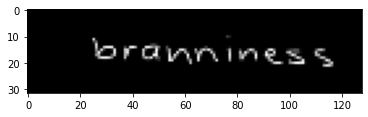



edit distance =  0
original_text =   glycolylurea
predicted text = glycolylurea

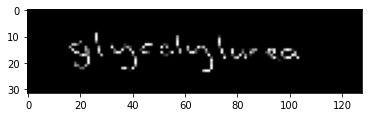



edit distance =  0
original_text =   divulgences
predicted text = divulgences

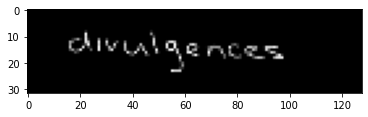



edit distance =  0
original_text =   bartramia
predicted text = bartramia

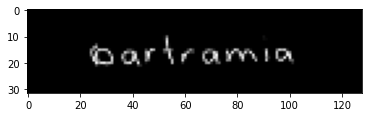



CER:  0.012211198223825713


In [37]:
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

total_character = 0
edit_distance = 0
# see the results (the lower CER the better)
for i, x in enumerate(out):
    original_text = valid_original_text[i]
    letters=''    
    for p in x:
        if int(p) != -1:
            letters += CHAR_LIST[int(p)]
            total_character += 1

    edit_cost = levenshtein_distance(original_text, letters)
    edit_distance += edit_cost

    if i % 1000 == 0:
        print("edit distance = ", edit_cost)
        print("original_text =  ", original_text)
        print("predicted text = ", end = '')
        for p in x:
            if int(p) != -1:
                print(CHAR_LIST[int(p)], end = '')
        plt.imshow(valid_images[i].reshape(32,128), cmap=plt.cm.gray)
        plt.show()
        print('\n')

In [39]:
print("CER: ", edit_distance/total_character)
print("Total edits: ", edit_distance)
print("Total Character: ", total_character)

CER:  0.012211198223825713
Total edits:  352
Total Character:  28826


In [ ]:
y